# Inspect the best model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.basic_train import _loss_func2activ

from matplotlib.colors import LinearSegmentedColormap

from captum.attr import Occlusion
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import visualization as viz

import convert
import shap

In [3]:
CONFIG = {
    "dir_dataset": Path("./clean_dataset"),
    "trained_weights": "resnet34_unfreeze_img_size_252_DDD-36",
    "validation_set": "valid.txt",
    "model": models.resnet34,
    "metric": [error_rate, accuracy],
    "img_size": 252,
    "batch_size": 64,
    "freeze": False
}

In [4]:
# function for getting label information out of train file name
# Example: p002_c0_img_3370 -> c0
get_y_fn = lambda x: x.stem.split("_")[1]

In [5]:
# create Databunch
data = (ImageList.from_folder(CONFIG["dir_dataset"])
        .split_by_fname_file(CONFIG["validation_set"])
        .label_from_func(get_y_fn)
        .transform(get_transforms(do_flip=False), size=CONFIG["img_size"])
        .databunch(bs=CONFIG["batch_size"])
        .normalize(imagenet_stats)
    )

In [6]:
# load the pretrained learner and set him to eval mode
trained_learner = cnn_learner(data, CONFIG["model"], metrics=CONFIG["metric"])
trained_learner.load(CONFIG["trained_weights"]) 
trained_learner.model.eval() ;

In [7]:
# take one random example from every class to investigate further

examples = {
    "c0": data.valid_ds[166],
    "c1": data.valid_ds[198],
    "c2": data.valid_ds[487],
    "c3": data.valid_ds[355],
    "c4": data.valid_ds[5],
    "c5": data.valid_ds[33],
    "c6": data.valid_ds[133],
    "c7": data.valid_ds[1],
    "c8": data.valid_ds[377]
}

# Inspect the examples using captum

In [8]:
def integrated_gradients_plot(model, input_img, target, cmap, n_steps=50):
    integrated_gradients = IntegratedGradients(model)
    attributions_ig = integrated_gradients.attribute(input_img,
                                                     target=target, n_steps=n_steps)

    _ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(input_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap=cmap,
                                 show_colorbar=True,
                                 sign='positive',
                                 outlier_perc=1)

In [9]:
def gradient_shap_plot(model, input_img, target, cmap, n_samples=50):
    torch.manual_seed(0)
    np.random.seed(0)

    gradient_shap = GradientShap(model)

    # Defining baseline distribution of images
    rand_img_dist = torch.cat([input_img * 0, input_img * 1])

    attributions_gs = gradient_shap.attribute(input_img,
                                              n_samples=n_samples,
                                              stdevs=0.0001,
                                              baselines=rand_img_dist,
                                              target=target)
    
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(input_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          ["original_image", "heat_map"],
                                          ["all", "absolute_value"],
                                          cmap=cmap,
                                          show_colorbar=True)

In [10]:
def occlusion_plot(model, input_img, target):
    occlusion = Occlusion(model)

    rand_img_dist = torch.cat([input_img * 0, input_img * 1])
    attributions_occ = occlusion.attribute(input_img,
                                           strides = (3, 50, 50),
                                           target=target,
                                           sliding_window_shapes=(3,60, 60),
                                           baselines=0)

    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.transpose(input_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          ["original_image", "heat_map"],
                                          ["all", "positive"],
                                          show_colorbar=True,
                                          outlier_perc=2,
                                         )

In [11]:
def model_wrapper(input_img_tensor):
    x = trained_learner.data.one_item(Image(input_img_tensor[0].cpu()))[0]
    return trained_learner.model(x)


Example:  c0 - safe driving

Network Prediction: c0



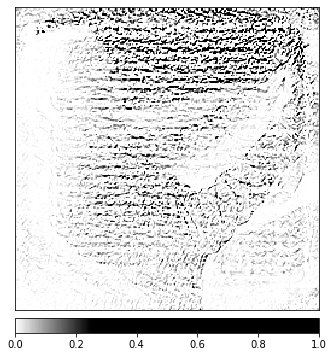

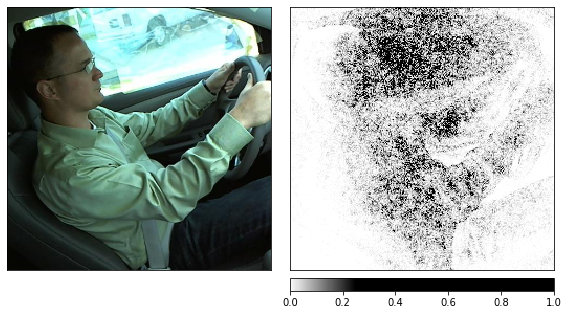

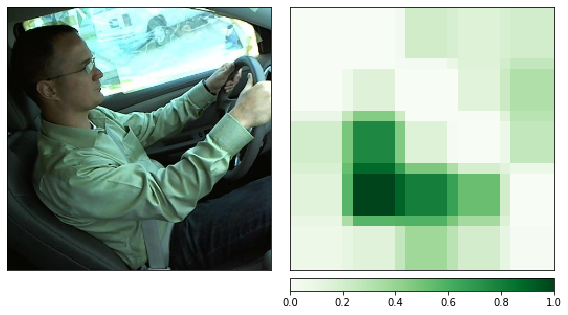


Example:  c1 - texting - right

Network Prediction: c1



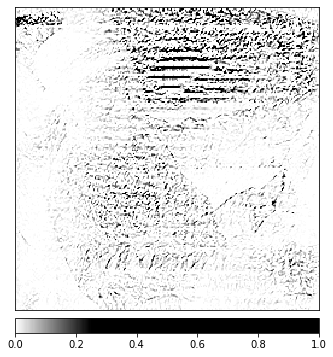

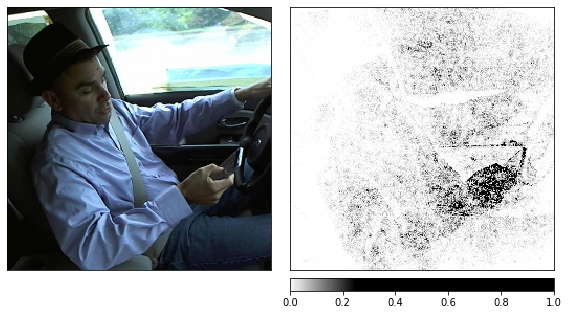

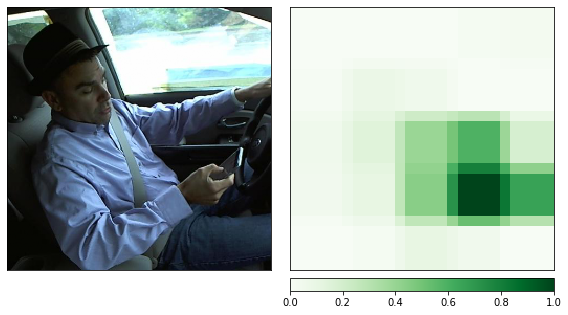


Example:  c2 - talking on the phone - right

Network Prediction: c2



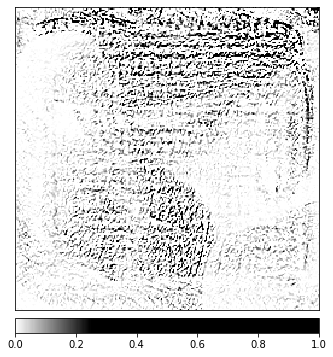

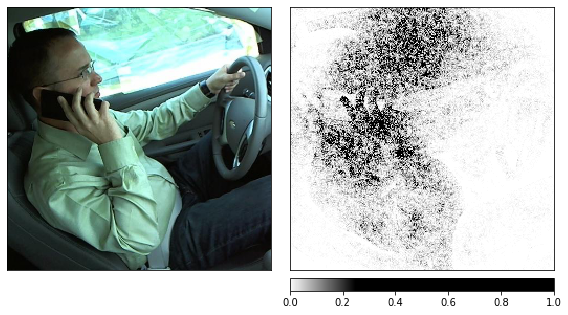

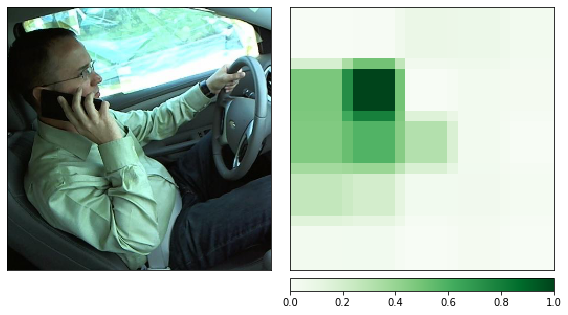


Example:  c3 - texting - left

Network Prediction: c3



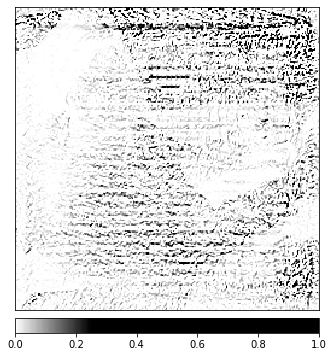

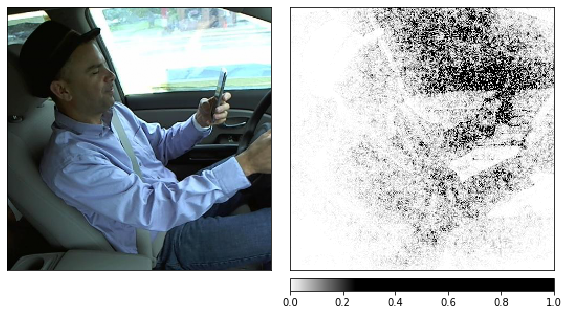

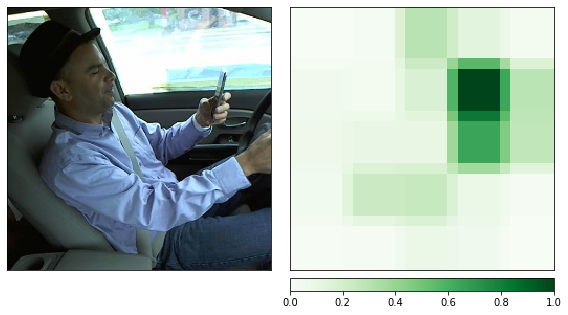


Example:  c4 - talking on the phone - left

Network Prediction: c4



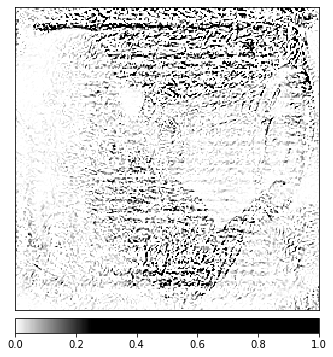

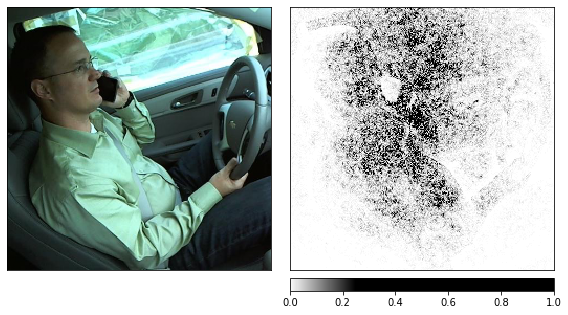

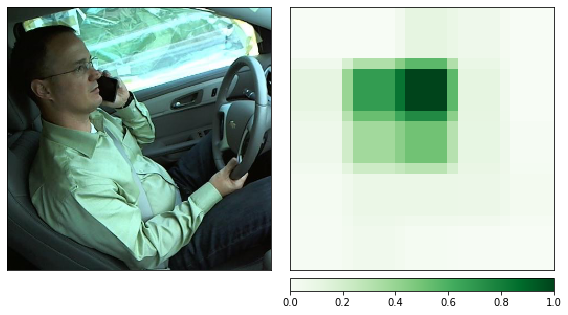


Example:  c5 - operating the radio

Network Prediction: c5



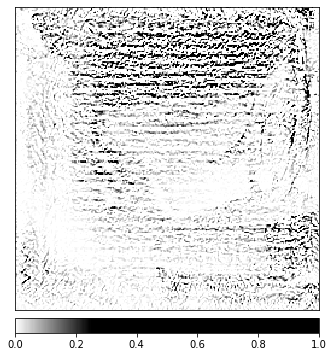

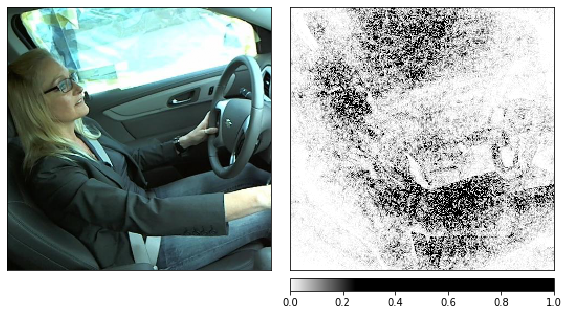

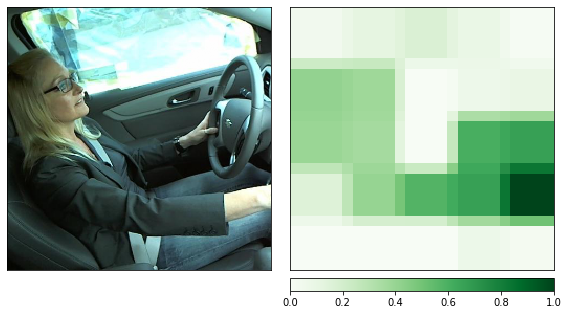


Example:  c6 - drinking

Network Prediction: c6



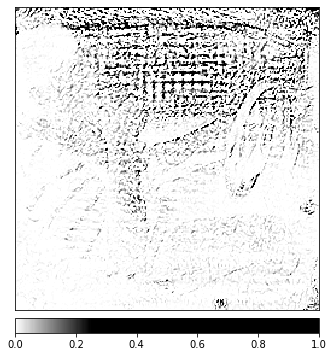

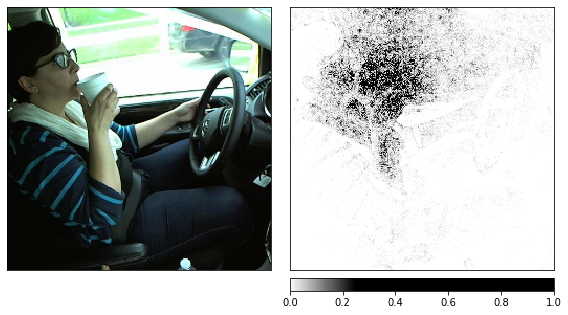

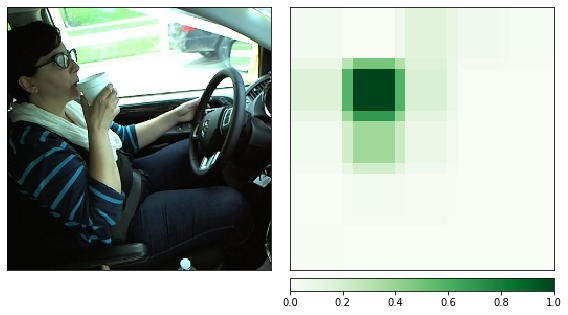


Example:  c7 - reaching behind

Network Prediction: c7



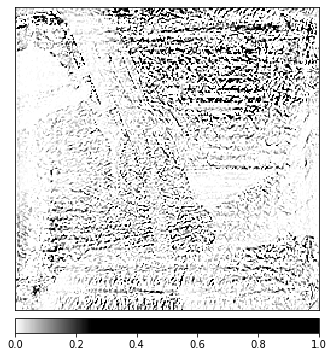

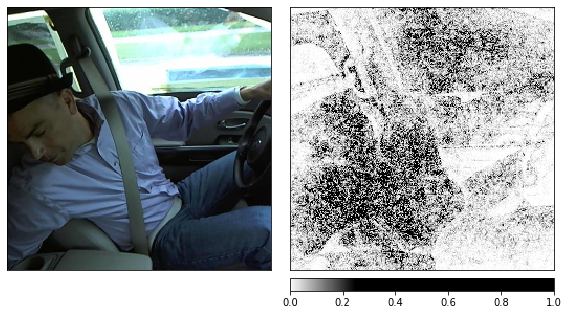

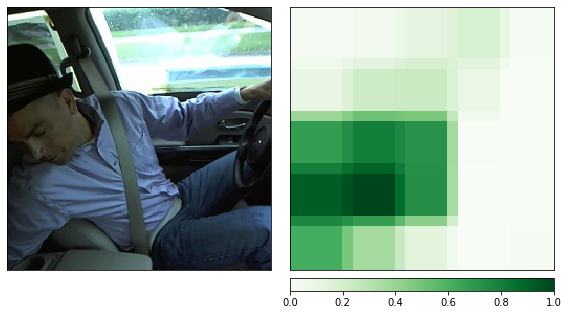


Example:  c8 - hair and makeup

Network Prediction: c8



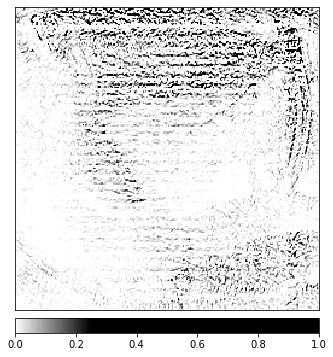

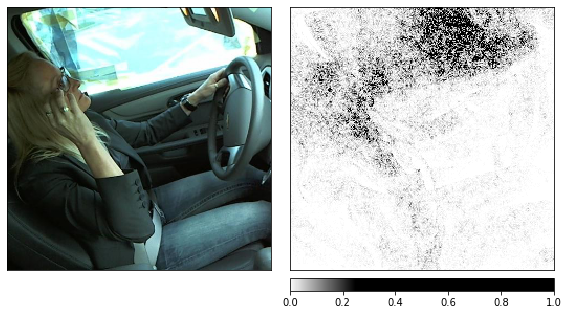

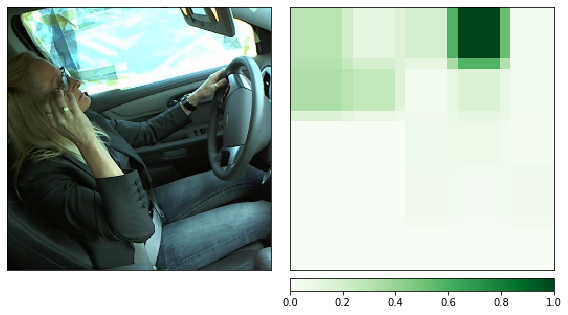

In [12]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
                                                 N=256)

# for every example create an integrated gradients, gradient shape and occlusion plot
for class_name, example_data in examples.items():
    input_img = example_data[0].data.reshape(1,3,CONFIG["img_size"],CONFIG["img_size"]).to("cuda")
    target = torch.tensor(example_data[1].data).type(torch.uint8).to("cuda")
    
    print()
    print("Example: ", " - ".join([class_name, convert.convert_label_to_description[class_name]]))
    print()
    print("Network Prediction: {}\n".format(trained_learner.predict(example_data[0])[0]))
    
    integrated_gradients_plot(model=model_wrapper, 
                              input_img=input_img, 
                              target=target, 
                              cmap=default_cmap, 
                              n_steps=100)
    
    gradient_shap_plot(model=model_wrapper, 
                       input_img=input_img, 
                       target=target, 
                       cmap=default_cmap, 
                       n_samples=100)
    
    occlusion_plot(model=model_wrapper, 
                   input_img=input_img, 
                   target=target)
    

# Inspect model using shap package

In [13]:
X = trained_learner.data.one_batch(DatasetType.Valid, detach=False, denorm=False, cpu=False)[0]

In [14]:
examples_as_tensor = torch.cat([trained_learner.data.one_item(value[0])[0] for value in examples.values()], 
                               dim=0).to("cuda")

In [15]:
e = shap.GradientExplainer((trained_learner.model), X)
shap_values,indexes = e.shap_values(examples_as_tensor, ranked_outputs=2, nsamples=200)

In [16]:
index_names = np.vectorize(lambda x: convert.convert_index_to_label[x])(indexes)

In [17]:
examples_as_tensor = torch.cat([value[0].data.reshape(1,3,CONFIG["img_size"],CONFIG["img_size"]) for value in examples.values()], 
                               dim=0).to("cuda")

In [18]:
# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
#to_explain_np = np.array([np.swapaxes(s, 0, 2) for s in to_explain.cpu().numpy()])
to_explain_np = np.rollaxis(examples_as_tensor.cpu().numpy(), 1, 4)

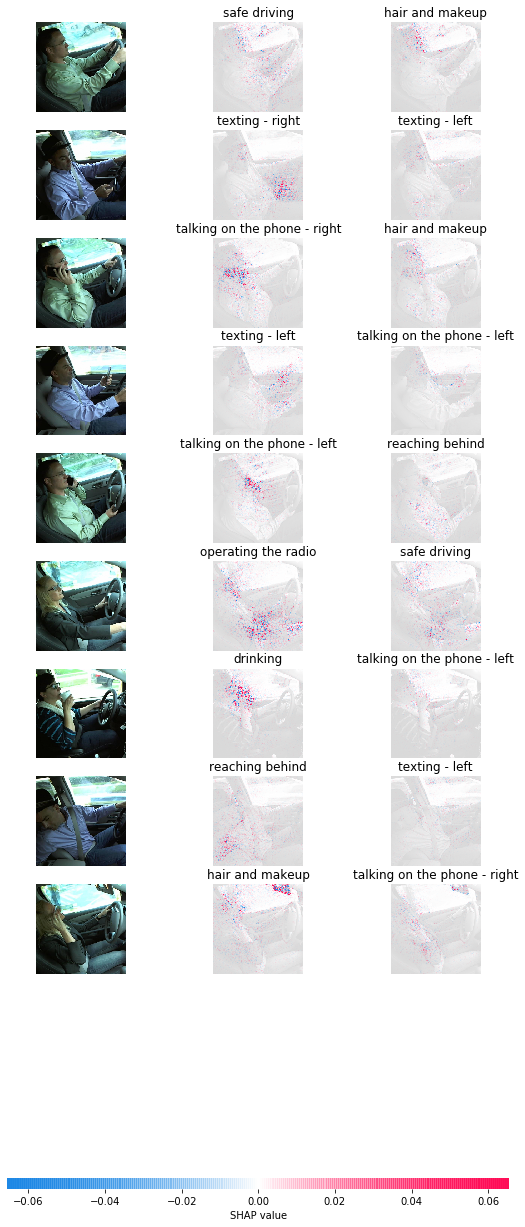

In [19]:
# plot the explanations
shap.image_plot(shap_values, to_explain_np, index_names, width=30)